In [100]:
import numpy as np
import matplotlib.pyplot as plt
import simpy
import random

## Part 2: Testing average waiting times

### Defining simpy processes

In [101]:
class Logger():
    """Keeps track of waiting times"""
    def __init__(self, env):
        self.env = env
        self.waiting_times = []

    def log_waiting_time(self, waiting_time):
        self.waiting_times.append(waiting_time)


def customer_generator(env, landa, mu, n_samples, logger):
    """Generates customers"""
    for k in range(n_samples):
        c = customer(env, f'Customer {k}', mu, logger)
        env.process(c)
        t = random.expovariate(landa) #Average inter_arrival_time
        yield env.timeout(t)

        
def customer(env, name, mu, logger):
    "Simulates queue behaviour and logs waiting times"
    arrival = env.now
#     print('yes')
    with counter.request() as req:
        yield req
        #Saving the time we waited 
        served = env.now
        waiting_time  = served - arrival
#         print(waiting_time)
        logger.log_waiting_time(waiting_time)
        #Getting served for X amount of time
        serving_time = random.expovariate(mu)
        yield env.timeout(serving_time)
        
        
def multiple_n_runs(landa, mu, ns, n_samples):
    '''Function that runs simulation for different server number n'''
    seed = random.randint(0, 2**32 - 1)
    random.seed(seed)
    time_logs = []
    for n in ns:
        env = simpy.Environment()
        counter = simpy.Resource(env, capacity=1)
        time_logger = Logger(env)
        proc = env.process(customer_generator(env, landa, mu, n_samples, time_logger))
        env.run(until=proc)
        time_logs.append(time_logger)  #Stores the waiting times for each simulation which involves a different numbers of servers given in the ns list
    return time_logs


In [102]:
ns = [1,2,4] #Stores the different number of servers for each simulation run. 
landa = 0.56
mu= 0.6
n_samples = 10**5 #Starting number of customers
p = landa/(1*mu)
lst = []

print(f'Utilization p = {p}')
for n in ns:
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=n)
    time_logger = Logger(env)
    proc = env.process(customer_generator(env, landa, mu, n_samples, time_logger))
    env.run(until=proc)
    lst.append(time_logger.waiting_times) #A list of waiting times for each customer in each simulation 1



Utilization p = 0.9333333333333335


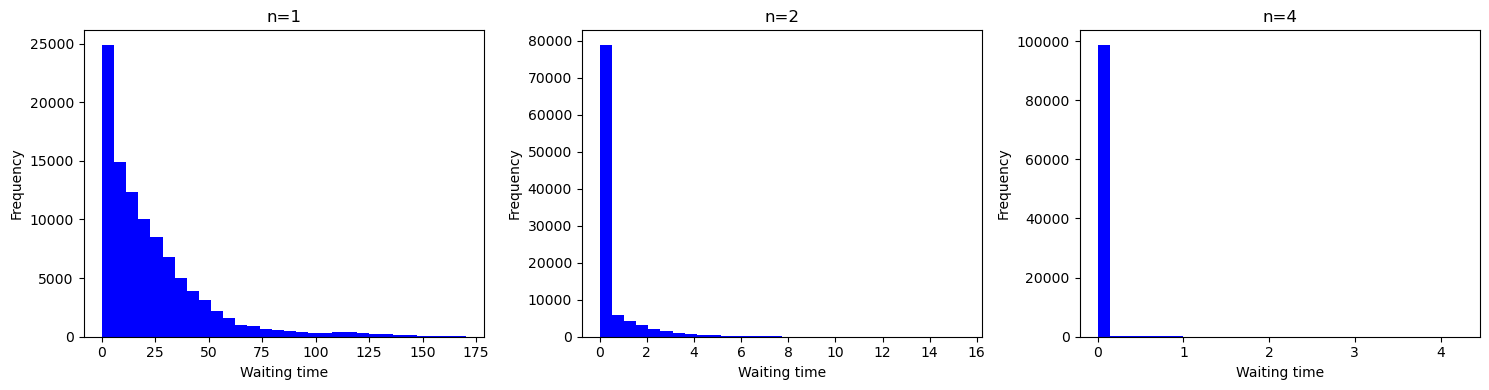

In [103]:
# Creating a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plotting each histogram in a separate subplot
for indx, t in enumerate(lst):
    axs[indx].hist(t, density = False, bins = 30, color= 'b')
    axs[indx].set_title(f"n={ns[indx]}")
    axs[indx].set_xlabel('Waiting time')
    axs[indx].set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()

# Display the subplots
plt.show()

## Part 4: Experimenting with different service rate distributions

### M/D/1 and M/D/n queues 

In [104]:
#Adjusting customer method to make customers wait for a constant rate of time (deterministic serving time)
def customer_md(env, logger):
    "Simulates queue behaviour and logs waiting times"
    arrival = env.now
#     print('yes')
    with counter.request() as req:
        yield req
        #Saving the time we waited 
        served = env.now
        waiting_time  = served - arrival
#         print(waiting_time)
        logger.log_waiting_time(waiting_time)
        #Getting served for X amount of time
        serving_time = 2.6335171907846533 #Setting a constant serving time (This is a cherry picked time from one of the times that would usually be generated by the expovariate function)
        yield env.timeout(serving_time)

#Adjusting customer method to account for customer_md method
def customer_generator_md(env, landa, mu, n_samples, logger):
    """Generates customers"""
    for k in range(n_samples):
        c = customer_md(env, logger)
        env.process(c)
        t = random.expovariate(landa) #inter_arrival_time is still drawn from exponential distribution
        yield env.timeout(t)

In [105]:
lst_md = []

for n in ns:
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=n)
    time_logger = Logger(env)
    proc = env.process(customer_generator_md(env, landa, mu, n_samples, time_logger)) #USING THE SAME PARAMETERS DEFINED ABOVE
    env.run(until=proc)
    lst_md.append(time_logger.waiting_times) #A list of waiting times for each customer in each simulation 1


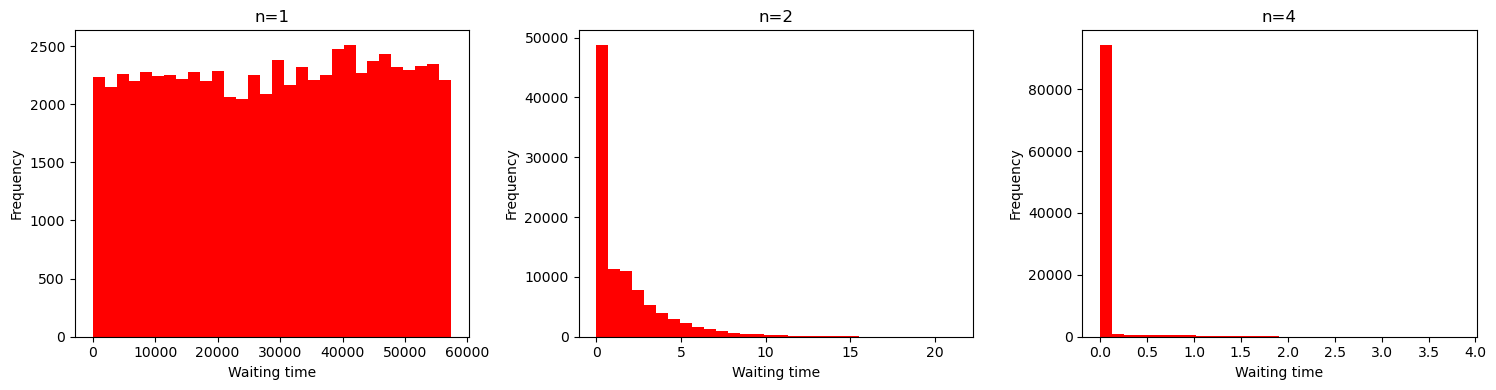

In [106]:
# Creating a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plotting each histogram in a separate subplot
for indx, t in enumerate(lst_md):
    axs[indx].hist(t, density = False, bins = 30, color= 'r')
    axs[indx].set_title(f"n={ns[indx]}")
    axs[indx].set_xlabel('Waiting time')
    axs[indx].set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()

# Display the subplots
plt.show()

#### Plots are now deterministic. High value for serving time was chosen

### Long tail distribution (Hyperexponential distribution)

In [237]:
#Define a method that generates random numbers from a hyperexponential distribution
def generate_hyperexp_num(probabilities,mus): 
    #probabilities = the probabilities of each mu occuring 
    #mus = different average service times

    #Check probabilities sum to 1

    if(sum(probabilities) != 1):

        raise ValueError("Probabilities must sum to 1")
    
    
    random_mu = random.choices(mus, weights=probabilities, k = 1) [0] #Select a random mu weighted by their probabilities. [0] ensures that the number is not returned in a list

    #print("SELECTED MU == " +str(random_mu))

    random_time = random.expovariate(1/random_mu) #Generate a random time based on a random mu -->

    return random_time

generate_hyperexp_num([0.75,0.25],[1,5])





0.7852125995668868

In [238]:

#Specify probabilities and mus (positions are matched to ensure probability in ps corresponds to mu in mus)
ps = [0.75,0.25]
mus = [1,5] 

#Adjusting customer method to make customers wait for a long tail rate of time (serving time drawn from hyperexponential distribution)

def customer_long_tail(env,logger):
    "Simulates queue behaviour and logs waiting times"
    arrival = env.now
#     print('yes')
    with counter.request() as req:
        yield req
        #Saving the time we waited 
        served = env.now
        waiting_time  = served - arrival
#         print(waiting_time)
        logger.log_waiting_time(waiting_time)
        #Getting served for X amount of time
        serving_time = generate_hyperexp_num(ps,mus) #Serving time according to hyperexponential distribution
        yield env.timeout(serving_time)

#Adjusting customer method to account for customer_md method
def customer_generator_long_tail(env, landa, n_samples, logger):
    """Generates customers"""
    for k in range(n_samples):
        c = customer_long_tail(env, logger)
        env.process(c)
        t = random.expovariate(landa) #inter_arrival_time is still drawn from exponential distribution
        yield env.timeout(t)

In [246]:
lst_long_tail = []

for n in ns:
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=n)
    time_logger = Logger(env)
    proc = env.process(customer_generator_long_tail(env, landa,n_samples, time_logger)) #USING THE SAME PARAMETERS DEFINED ABOVE
    env.run(until=proc)
    lst_long_tail.append(time_logger.waiting_times) #A list of waiting times for each customer in each simulation 1

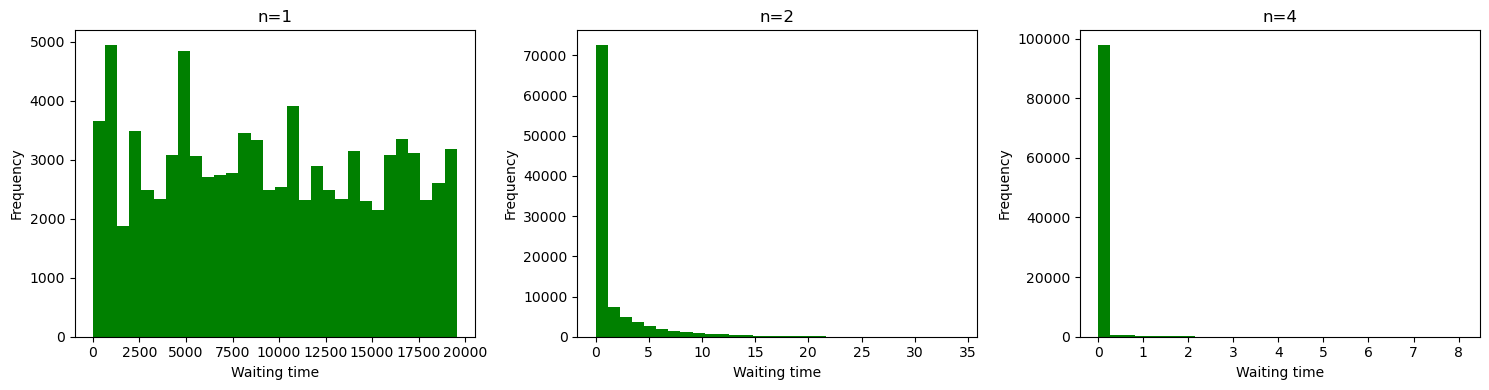

In [247]:
# Creating a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plotting each histogram in a separate subplot
for indx, t in enumerate(lst_long_tail):
    axs[indx].hist(t, density = False, bins = 30, color= 'g')
    axs[indx].set_title(f"n={ns[indx]}")
    axs[indx].set_xlabel('Waiting time')
    axs[indx].set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()

# Display the subplots
plt.show()